# This notebook demonstrates how to monitor the training of a classifier on CIFAR-10 
##### We follows this tutorial: https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


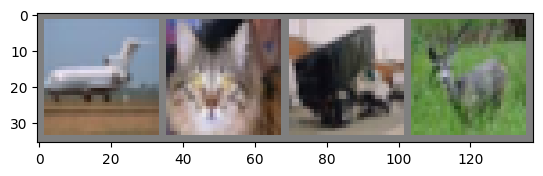

plane cat   truck deer 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
import wandb

wandb.init(project="cifar-10", entity='sbordt-University of Tübingen')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sbordt (sbordt-University of Tübingen). Use `wandb login --relogin` to force relogin


In [8]:
from pytorch_module_monitor import ModuleMonitor

# initialize the training monitor
# setup monitoring
# define the metrics that we use for monitoring. currently this is the same as the default, but here you see how to define custom metrics :)
def l2_norm(tensor: torch.Tensor) -> torch.Tensor:
    """we compute the metric along the last dimension, which is the embedding dimension. then we just return the remaining tensor of shape BxS (input shape is BxSxE)"""
    return torch.linalg.vector_norm(tensor, ord=2, dim=-1)

def matrix_opnorm(tensor: torch.Tensor) -> torch.Tensor:
    return torch.linalg.matrix_norm(tensor, ord=2)

activation_metrics = {
    "l2norm": l2_norm,
}
parameter_metrics_spec = {
    r".*": {"l2norm": lambda param: l2_norm(param.flatten())},                      # l2 norm for all parameters
}
gradient_metrics = {
    "l2norm": l2_norm,
}

# create the training monitor
training_monitor = ModuleMonitor(monitor_interval=100, 
                                 activation_metrics=activation_metrics,
                                 parameter_metrics_spec=parameter_metrics_spec,
                                 gradient_metrics=gradient_metrics)

# provide the module that we want to monitor
training_monitor.set_module(net)


In [9]:
gradient_step = 1
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        ### Tell the monitor that we are starting a new gradient step ###
        training_monitor.start_step(gradient_step)

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        ### Tell the monitor that we are done with the gradient step ###
        training_monitor.after_micro_batch()
        training_monitor.monitor_parameters()
        training_monitor.monitor_gradients()

        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

        gradient_step += 1
        training_monitor.aggregate_step()

        # log everything to wandb
        metrics = {
            "loss": running_loss / 2000,
            "epoch": epoch,
            "step": gradient_step,
        }
        metrics.update(training_monitor.get_metrics())
        wandb.log(metrics)

print('Finished Training')

[1,  2000] loss: 2.221
[1,  4000] loss: 1.865
[1,  6000] loss: 1.685
[1,  8000] loss: 1.565
[1, 10000] loss: 1.513
[1, 12000] loss: 1.472
[2,  2000] loss: 1.404
[2,  4000] loss: 1.370
[2,  6000] loss: 1.320
[2,  8000] loss: 1.318
[2, 10000] loss: 1.296
[2, 12000] loss: 1.260
Finished Training


In [10]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor